In [40]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [41]:
# gpu를 쓸 거면 cuda위에 올려서 하고, 아니면 cpu를 사용해라 !
DEVICE = 'cuda'if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [42]:
transform = transforms.ToTensor()

In [43]:
download_root = './MNIST_DATASET'

train_DS = datasets.MNIST(download_root, transform=transform, train=True, download=True)
valid_DS = datasets.MNIST(download_root, transform=transform, train=False, download=True)
test_DS = datasets.MNIST(download_root, transform=transform, train=False, download=True)

In [44]:
train_DS

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST_DATASET
    Split: Train
    StandardTransform
Transform: ToTensor()

In [45]:
train_DS.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [46]:
train_DS.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [47]:
train_DS.data.shape

torch.Size([60000, 28, 28])

In [48]:
train_DS.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

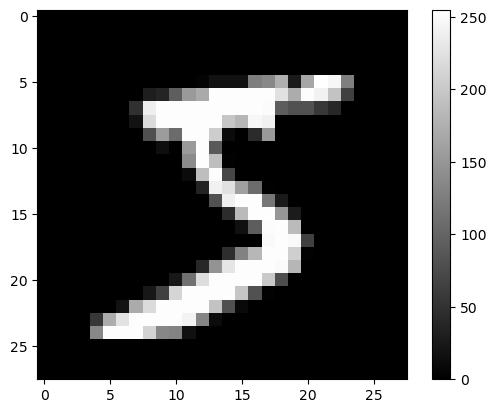

In [49]:
plt.imshow(train_DS.data[0], cmap='gray')
plt.colorbar()

In [50]:
train_DS.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [51]:
train_DS.targets.shape

torch.Size([60000])

### DataLoader 구경

- 데이터를 랜덤하게 뽑아야 함

In [52]:
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [53]:
len(train_DL.dataset)

60000

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.Size([28, 28])
tensor(2)
torch.uint8
torch.float32


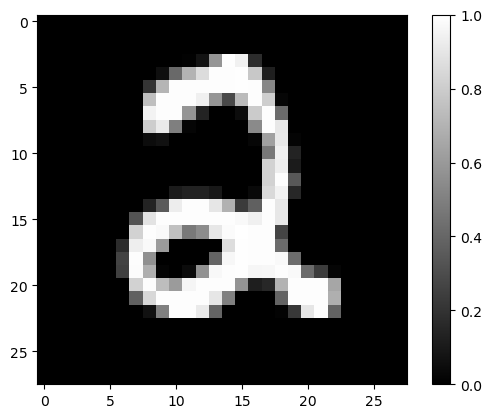

In [54]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 국자
print(type(train_DS.data))
print(type(x_batch))
print(x_batch.shape)
print(y_batch.shape)
print(x_batch[0].squeeze().shape)
plt.imshow(x_batch[0].squeeze(), cmap='gray')
plt.colorbar()
print(y_batch[0])

print(train_DL.dataset.data.dtype)
print(x_batch.dtype)
# ToTensor 의 역할
# 1. tensor로 바꿔준다
# 2. 개채행열로 바꿔준다
# 3. 0~1 사이로 바꿔준다 (int -> float)

### Model 만들기

In [55]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(28*28, 100),
                                    nn.ReLU(),
                                    nn.Linear(100, 10))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # (32, 784의 입력을 기대하기 때문에 flatten)
        x = self.linear(x)
        return x


In [56]:
# flatten 확인

x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
flat_images = torch.flatten(x_batch)
print(flat_images.shape)
flat_images2 = torch.flatten(x_batch, start_dim=1)
print(flat_images2.shape)

torch.Size([32, 1, 28, 28])
torch.Size([25088])
torch.Size([32, 784])


In [57]:
model = MLP()
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch).shape)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([32, 10])


### model 훈련시키기

In [58]:
from torch import optim
LR = 0.1
EPOCH = 500
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def Train(model, train_DL, criterion, optimizer):
    loss_history = []
    NoT = len(train_DL.dataset) # 60000

    model.train() # train mode로 전환
    for ep in range(EPOCH):
        rloss = 0 # running loss
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기회
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE를 곱하면 마지막 18개도 32개를 곱하게 된다.
            rloss += loss_b
        # print loss
        loss_e = rloss/NoT
        loss_history += [loss_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e, 3)}")
        print("-"*20)
    return loss_history

### Cross Entropy 확인 (왜 모델에 softmax를 붙히지 않았는가?)

In [60]:
# cross entropy 구하는 여러가지 방법
import torch.nn.functional as F

y_hat = torch.randn(3, 5) # data는 세 개 , 5 종류로 분류하는 문제 가정 (5개의 노드로 나옴)
print(y_hat) # 아직 가로축으로 합이 1이 아님 (그냥 랜덤하게 뽑았음). softmax 통과해야 합이 1나옴
y_batch = torch.randint(5, (3,))
print(y_batch) # 각각 n번째 데이터에 대한 정답 # 만약 [3, 0 ,1] 이면 첫번째 데이터는 [0, 0, 0, 1, 0]이 되도록 만들어야 함.

# 방법 1 # softmax 내장
loss = F.cross_entropy(y_hat, y_batch)
print(loss)

# 방법 2 # softmax 내장
criterion = nn.CrossEntropyLoss()
print(criterion(y_hat, y_batch))

# 방법 1, 방법 2 에는 softmax가 안에 포함되어 있기 때문에 softmax를 통과하지 않는다

# 방법 3 (직접 만들기)
y_hat_soft = F.softmax(y_hat, dim=1)
print(y_hat_soft)
loss = 0
for i, val in enumerate(y_hat_soft):
    print(i, val)
    loss += -torch.log(val[y_batch[i]]) # loss에 누적 # i 번째 값에 log 취해줌
    print('loss =', loss)
print(loss/3) # 평균이 내장되어 있다

tensor([[-0.1406, -0.0787,  1.5258,  0.8446, -0.4147],
        [-0.7233,  0.3166, -0.9340,  0.5381,  1.2254],
        [ 1.1073,  0.0205, -0.1328, -0.1122,  1.2306]])
tensor([4, 1, 1])
tensor(2.1790)
tensor(2.1790)
tensor([[0.0926, 0.0985, 0.4903, 0.2481, 0.0704],
        [0.0658, 0.1863, 0.0533, 0.2324, 0.4621],
        [0.3275, 0.1105, 0.0948, 0.0967, 0.3705]])
0 tensor([0.0926, 0.0985, 0.4903, 0.2481, 0.0704])
loss = tensor(2.6533)
1 tensor([0.0658, 0.1863, 0.0533, 0.2324, 0.4621])
loss = tensor(4.3339)
2 tensor([0.3275, 0.1105, 0.0948, 0.0967, 0.3705])
loss = tensor(6.5369)
tensor(2.1790)


### 모델 학습시키기

Epoch: 1, train loss: 0.311
--------------------
Epoch: 2, train loss: 0.146
--------------------
Epoch: 3, train loss: 0.102
--------------------
Epoch: 4, train loss: 0.076
--------------------
Epoch: 5, train loss: 0.061
--------------------


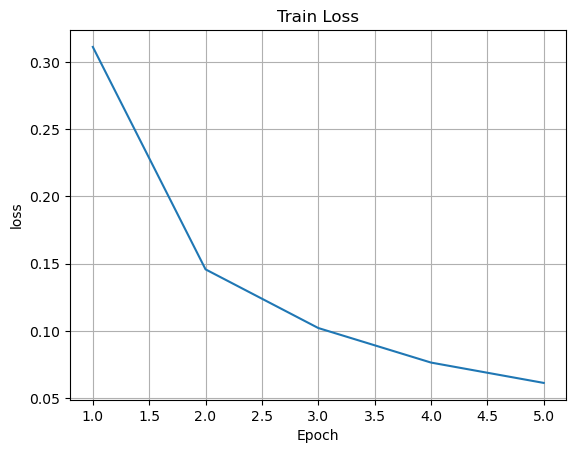

In [63]:
model = MLP().to(DEVICE) # x_batch, y_batch, model 까지 DEVICE에 올려줘야 함.
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_history = Train(model, train_DL, criterion, optimizer)

plt.plot(range(1, EPOCH+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Train Loss')
plt.grid()

### 모델 저장하기 & 불러오기

In [65]:
save_model_path = '../pytorch_1/MLP_MNIST.pt'
torch.save(model.state_dict(), save_model_path)
# model.state_dict()

In [66]:
load_model = MLP().to(DEVICE)
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

<All keys matched successfully>

### 모델 테스트하기

In [67]:
def Test(model, test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # accuracy accumulation
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")

In [68]:
Test(load_model, test_DL)

Test accuracy: 9753/10000 (97.5 %)


In [69]:
# 파라미터 수 구하기
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [70]:
print(count_params(load_model))

79510
